## Part A: Document Clustering

## Load required libraries

In [3]:
install.packages("SnowballC")

package 'SnowballC' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\mkha0052\AppData\Local\Temp\RtmpM1oLZ0\downloaded_packages


In [4]:
install.packages("tm")

also installing the dependencies 'NLP', 'slam'



package 'NLP' successfully unpacked and MD5 sums checked
package 'slam' successfully unpacked and MD5 sums checked
package 'tm' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\mkha0052\AppData\Local\Temp\RtmpM1oLZ0\downloaded_packages


In [5]:
library(SnowballC)
library(tm)
library(dplyr)

Loading required package: NLP

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



## Read The Required Datasets using the function provided.

* Load the corpus;
* Preprocess the data, which involves :
    * removing stopwords,punctuations and redundant spaces;
    * removing alphanumeric charachters;
    * Perform Stemming on the words of the document;
    * converting the entire dataset into lowercase;
    *  Create a matrix which its rows are the documents and colomns are the words;
    * Remove sparse terms i.e. relative document frequency for a term
    

In [12]:
#You are welcome to use this code for your submission if you would like to; otherwise, you are welcome to use your own code that you have developed so far. 

# The main aim is to help you folks to move forward to interesting parts of the Assessment, and to not get stuck in some implementation details.
# Carefully note the comments throughout the code, particularly theo nes relating to handle small numbers in the log space and how to prevent NaN 
# when normalising a non-negative vector to get probability distribution. 
#========


# You may need to install some packages:
#install.packages('tm')
#install.packages('SnowballC')

eps=1e-10
  
# reading the data
read.data <- function(file.name='dataset/Task2A.txt', sample.size=1000, seed=100, pre.proc=TRUE, spr.ratio= 0.90) {
  # INPUTS:
  ## file.name: name of the input .txt file
  ## sample.size: if == 0  reads all docs, otherwise only reads a subset of the corpus
  ## seed: random seed for sampling (read above)
  ## pre.proc: if TRUE performs the preprocessing (recommended)
  ## spr.ratio: is used to reduce the sparcity of data by removing very infrequent words
  # OUTPUTS:
  ## docs: the unlabled corpus (each row is a document)
  ## word.doc.mat: the count matrix (each rows and columns corresponds to words and documents, respectively)
  ## label: the real cluster labels (will be used in visualization/validation and not for clustering)
  
  # Read the data
  text <- readLines(file.name)
  # select a subset of data if sample.size > 0
  if (sample.size>0){
    set.seed(seed)
    text <- text[sample(length(text), sample.size)]
  }
  ## the terms before the first '\t' are the lables (the newsgroup names) and all the remaining text after '\t' are the actual documents
  docs <- strsplit(text, '\t')
  # store the labels for evaluation
  labels <-  unlist(lapply(docs, function(x) x[1]))
  # store the unlabeled texts    
  docs <- data.frame(doc_id=1:length(docs),text=unlist(lapply(docs, function(x) x[2])))

  library(tm)
  # create a corpus
  docs <- DataframeSource(docs)
  corp <- Corpus(docs)
  
  # Preprocessing:
  if (pre.proc){
    corp <- tm_map(corp, removeWords, stopwords("english")) # remove stop words (the most common word in a language that can be find in any document)
    corp <- tm_map(corp, removePunctuation) # remove pnctuation
    corp <- tm_map(corp, stemDocument) # perform stemming (reducing inflected and derived words to their root form)
    corp <- tm_map(corp, removeNumbers) # remove all numbers
    corp <- tm_map(corp, stripWhitespace) # remove redundant spaces 
  }  
  # Create a matrix which its rows are the documents and colomns are the words. 
  dtm <- DocumentTermMatrix(corp)
  ## reduce the sparcity of out dtm
  dtm <- removeSparseTerms(dtm, spr.ratio)
  ## convert dtm to a matrix
  word.doc.mat <- t(as.matrix(dtm))
  
                                   
  # Return the result
  return (list("docs" = docs, "word.doc.mat"= word.doc.mat, "labels" = labels))
}

In [13]:
text_data <- read.data(file.name='Task2A.txt', sample.size=0, seed=100, pre.proc=TRUE, spr.ratio= .99)

## Implement the hard EM and soft EM .

#### Helper Functions

In [19]:
# Input:    logA1, logA2 ... logAn
# Output:   log(A1+A2+...+An)
#
# This function is needed to prevent numerical overflow/underflow when working with small numbers, 
# because we can easily get small numbers by multiplying p1 * p2 * ... * pn (where 0 <= pi <= 1 are probabilities).   
#
# Example: Suppose we are interested in p1*p2*p3 + q1*q2+q3 where all numbers are probabilities \in [0,1]
#          To prevent numerical errors, we do the computation in the log space and convert the result back using the exp function 
#          Hence our approach is to form the vector v = [log(p1)+log(p2)+log(p3) , log(q1)+log(q2)+log(q3)] 
#          Then get the results by: exp(logSum(v))
logSum <- function(v) {
   m = max(v)
   return ( m + log(sum(exp(v-m))))
}

In [20]:
##--- Initialize model parameters randomly --------------------------------------------
initial.param <- function(vocab_size, K=4, seed=123456){
  rho <- matrix(1/K,nrow = K, ncol=1)                    # assume all clusters have the same size (we will update this later on)
  mu <- matrix(runif(K*vocab_size),nrow = K, ncol = vocab_size)    # initiate Mu 
  mu <- prop.table(mu, margin = 1)               # normalization to ensure that sum of each row is 1
  return (list("rho" = rho, "mu"= mu))
}

## Hard EM

In [52]:
#Estimation function for Hard Max
E_hard.step <- function(gamma, model, counts){
  # Model Parameter Setting
  N <- dim(counts)[2] # number of documents
  K <- dim(model$mu)[1]
  # E step:    
  for (n in 1:N){
    for (k in 1:K){
      ## calculate the posterior based on the estimated mu and rho in the "log space"
      gamma[n,k] <- log(model$rho[k,1]) +  sum(counts[,n] * log(model$mu[k,])) 
    }
    # normalisation to sum to 1 in the log space
    
    logZ = logSum(gamma[n,])
    gamma[n,] = gamma[n,] - logZ
    
  
  }
  #hard EM
  # Zn,k =1 if the document/datapoint belongfs to that cluster otherwise 0, so we calculate the posterior 
# probability that is gamma so basically the maximum probability of a document lying in a specific cluster
# means it is most likely to be in that cluster and then the in zn,k the value of that specific cluster for that datapoint
## becomes 1.
    max_cluster_probabilty <- gamma==apply(gamma, 1, max) # for each point find the cluster with the maximum (estimated) probability
    gamma[ max_cluster_probabilty] <- 1 # assign each point to the cluster with the highest probability and update the zn,k for that cluster to 1
    gamma[! max_cluster_probabilty] <- 0 # else 0

    return (gamma)
}

## Soft EM

In [27]:
##--- E Step for Document Clustering  --------------------------------------------
# this function currently implements the E-step of the soft-EM
# Student needs to modify this function if wants to make it Hard-EM 
#
E_soft.step <- function(gamma, model, counts){
  # Model Parameter Setting
  N <- dim(counts)[2] # number of documents
  K <- dim(model$mu)[1]

  # E step:    
  for (n in 1:N){
    for (k in 1:K){
      ## calculate the posterior based on the estimated mu and rho in the "log space"
      gamma[n,k] <- log(model$rho[k,1]) +  sum(counts[,n] * log(model$mu[k,])) 
    }
    # normalisation to sum to 1 in the log space
    logZ = logSum(gamma[n,])
    gamma[n,] = gamma[n,] - logZ
  }
  
  # converting back from the log space 
  gamma <- exp(gamma)
  return (gamma)
}

## Maximization Step for Hard and Soft EM

In [42]:
##--- M Step for Hard EM  --------------------------------------------
M.step <- function(gamma, model, counts){
  # Model Parameter Setting
  N <- dim(counts)[2]   # number of documents
  W <- dim(counts)[1]   # number of words i.e. vocabulary size
  K <- dim(model$mu)[1] # number of clusters
  Nk.hat<-model$rho
  mu<-model$mu
    for (k in 1:K){
        
        # the effective number of point in cluster k
        
      
         Nk.hat[k]<-sum(gamma[,k])/N 
    }
    # assign that probability of each cluster
    model$rho<- Nk.hat
   
    for (k in 1:K){
        
       for (w in 1:W)
        {     
    # calculate probability of each word belonging to the all of the three clusters
# # this prevents NaN for vectors where all elements are zero such as [0,0,0] because after adding eps you have [eps,eps,eps] which 
  # results in the uniform distribution after normalisation. 
            val<-(counts[w,] * gamma[,k]) + eps
            mu[k,w]<-sum(val* gamma[,k])/(sum(counts * gamma[,k])+K*eps)
          
          
       }
      
        
    }
  #NORMALIZE it to one 
    model$mu<-prop.table(mu, margin = 1)
    
    
  
  # Return the result
  return (model)
}
    
    

In [46]:
##--- EM for Document Clustering --------------------------------------------
EM <- function(counts, K=4, max.epoch=10,method, seed=123456){
  #INPUTS:
  ## counts: word count matrix
  ## K: the number of clusters
  #OUTPUTS:
  ## model: a list of model parameters
 if (method=='Soft EM') {
     

  # Model Parameter Setting
  N <- dim(counts)[2] # number of documents
  W <- dim(counts)[1] # number of unique words (in all documents)
  
  # Initialization
  model <- initial.param(W, K=K, seed=seed)
  gamma <- matrix(0, nrow = N, ncol = K)

  print(train_obj(model,counts))
  # Build the model
  for(epoch in 1:max.epoch){
    
    # E Step
    gamma <- E_soft.step(gamma, model, counts)
    # M Step
    model <- M.step(gamma, model, counts)
   
     
  }
  # Return Model
  return(list("model"=model,"gamma"=gamma))
}
    
else if(method=='Hard EM')
{
    
  #INPUTS:
  ## counts: word count matrix
  ## K: the number of clusters
  #OUTPUTS:
  ## model: a list of model parameters
  
  # Model Parameter Setting
  N <- dim(counts)[2] # number of documents
  W <- dim(counts)[1] # number of unique words (in all documents)
  
  # Initialization
  model <- initial.param(W, K=K, seed=seed)
  gamma <- matrix(0, nrow = N, ncol = K)

  print(train_obj(model,counts))
  # Build the model
  for(epoch in 1:max.epoch){
    
    # E Step
    gamma <- E_hard.step(gamma, model, counts)
    # M Step
    model <- M.step(gamma, model, counts)
   
   
  }
  # Return Model
  return(list("model"=model,"gamma"=gamma))
}
}
    

In [47]:
##--- the training objective function --------------------------------------------
# Input: 
#    model:  the model object containing the mu and rho
#    counts: the word-document frequency matrix
# Output:
#    nloglike: the negative log-likelihood i.e. log P(counts|model) 
#   
train_obj <- function(model, counts) { 
  N <- dim(counts)[2] # number of documents
  K <- dim(model$mu)[1]
   
  nloglike = 0
  for (n in 1:N){
    lprob <- matrix(0,ncol = 1, nrow=K)
    for (k in 1:K){
      lprob[k,1] = sum(counts[,n] * log(model$mu[k,])) 
    }
    nloglike <- nloglike - logSum(lprob + log(model$rho))
  }
  
  return (nloglike)
}

In [48]:
##--- Cluster Visualization -------------------------------------------------
cluster.viz <- function(doc.word.mat, color.vector, title=' '){
  p.comp <- prcomp(doc.word.mat, scale. = TRUE, center = TRUE)
  plot(p.comp$x, col=color.vector, pch=1,  main=title)
}

[1] 2172100


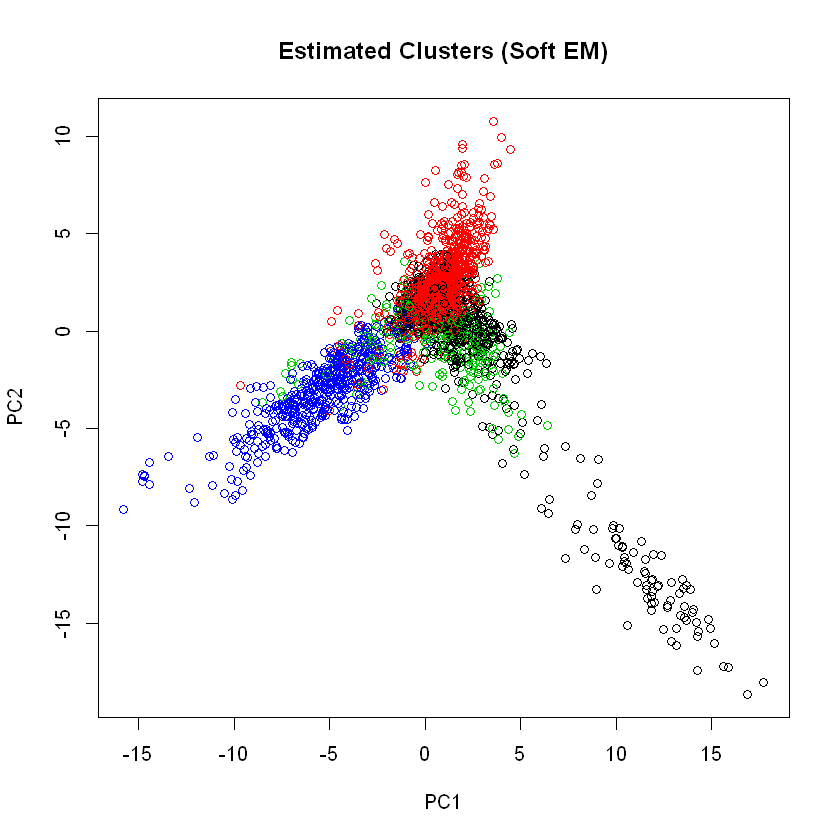

In [50]:
# word-document frequency matrix 
counts <- text_data$word.doc.mat        
# below is toy data if you want to work with
# counts <- matrix(c(1,1,0,1,0,0,0,1,1,1,0,1,0,0,1,1,0,0),nrow=3,ncol=6)
# calling the EM algorithm on the data
res <- EM(counts, K=4, max.epoch=5,'Soft EM')   

# visualization
## find the cluster with the maximum probability (since we have soft assignment here)
label.hat <- apply(res$gamma, 1, which.max) 
## normalize the count matrix for better visualization
counts<-scale(counts) # only use when the dimensionality of the data (number of words) is large enough

## visualize the stimated clusters
cluster.viz(t(counts), label.hat, 'Estimated Clusters (Soft EM)')


[1] 2178511


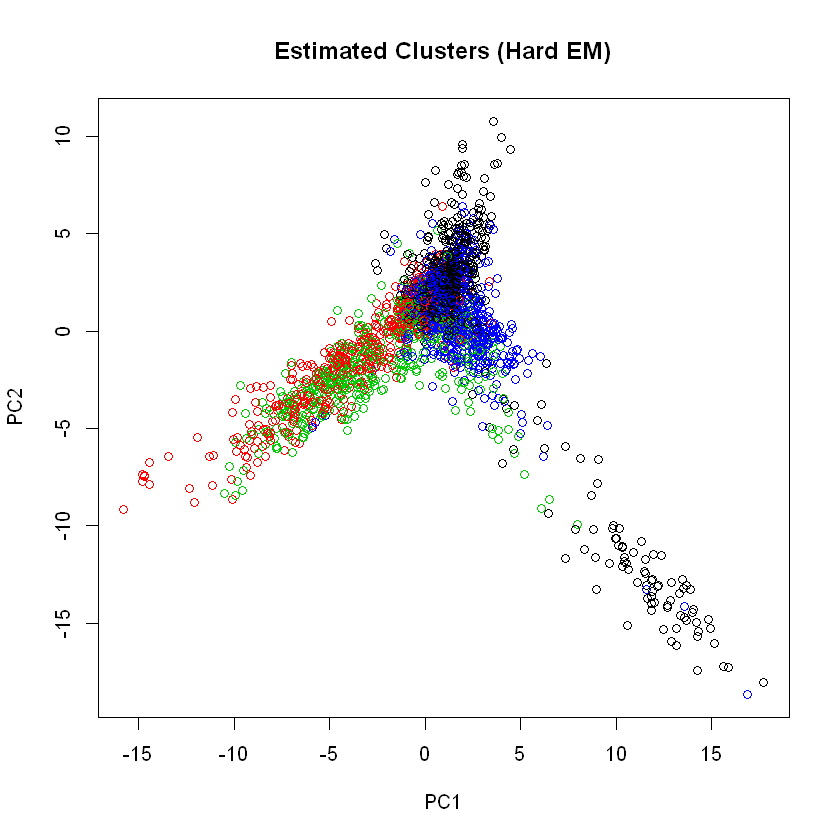

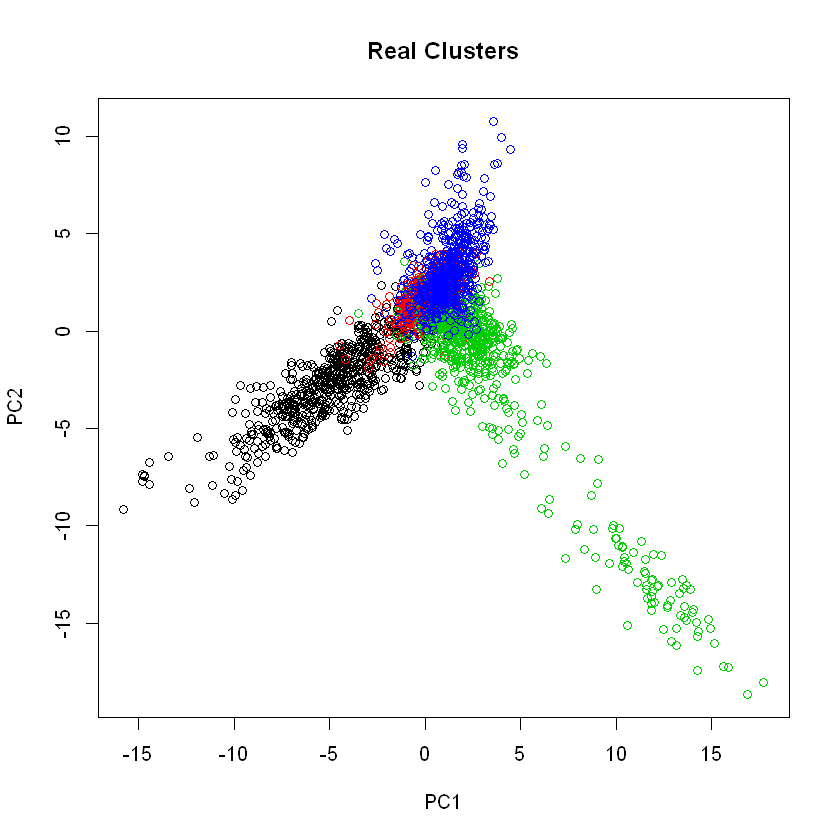

In [53]:
# word-document frequency matrix 
counts <- text_data$word.doc.mat 

# below is toy data if you want to work with
#counts <- matrix(c(1,1,0,1,0,0,0,1,1,1,0,1,0,0,1,1,0,0),nrow=3,ncol=6)
# calling the EM algorithm on the data
res <- EM(counts, K=4, max.epoch=4,'Hard EM')   

# visualization
## find the culster with the maximum probability (since we have soft assignment here)
label.hat <- apply(res$gamma, 1, which.max) 
## normalize the count matrix for better visualization
counts<-scale(counts) # only use when the dimensionality of the data (number of words) is large enough
## visualize the estimated clusters
cluster.viz(t(counts), label.hat, 'Estimated Clusters (Hard EM)')

## visualize the real clusters
cluster.viz(t(counts), factor(text_data$label), 'Real Clusters')